# Joint project AMD + SM2L

https://docs.google.com/document/d/1oqoIyRUI_digfIokf53fox0I1eWiTFzQaae-PxMre0Y/edit

The task is to implement from scratch a learning algorithm for **regression** with **square loss** (e.g., **ridge regression**). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:
- PERNP (Person's earnings)
- PINCP (Person's income)
- WAGP (Wages or salary income past 12 months)
- HINCP (Household income)
- FINCP (Family income)

This code is run inside the Docker container provided in the course.

## Install PySpark

In the docker-compose given in the course, PySpark is already installed, but not in Google Colab. The following cell has to be executed if the notebook is not run in the docker-compose provided by the course, so it has the objective to install Spark on the current machine.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import os
import findspark
from pyspark.sql import SparkSession
import pyspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

findspark.init("spark-2.4.5-bin-hadoop2.7")     # SPARK_HOME
spark = SparkSession.builder.master("local[*]").getOrCreate()
type(spark)

In [56]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.5
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_252
Branch HEAD
Compiled by user centos on 2020-02-02T19:38:06Z
Revision cee4ecbb16917fa85f02c635925e2687400aa56b
Url https://gitbox.apache.org/repos/asf/spark.git
Type --help for more information.


## Dataset

The project is based on the analysis of the «2013 American Community Survey» dataset published on Kaggle and released under the public domain license (CC0).

https://www.kaggle.com/census/2013-american-community-survey

The American Community Survey is an ongoing survey from the US Census Bureau. In this survey, approximately 3.5 million households per year are asked detailed questions about who they are and how they live. Many topics are covered, including ancestry, education, work, transportation, internet use, and residency.

There are two types of survey data provided, housing and population:
- For the housing data, each row is a housing unit, and the characteristics are properties like rented vs. owned, age of home, etc.
- For the population data, each row is a person and the characteristics are properties like age, gender, whether they work, method/length of commute, etc.

Each data set is divided in two pieces, "a" and "b":
- "a" contains states 1 to 25;
- "b" contains states 26 to 50.

Both data sets have weights associated with them. Weights are included to account for the fact that individuals are not sampled with equal probably (people who have a greater chance of being sampled have a lower weight to reflect this):
- Weight variable for the housing data: WGTP
- Weight variable for the population data: PWGTP

### Setup Kaggle API

In [1]:
!python -c "print('y')" | pip uninstall kaggle

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Would remove:
    /home/jovyan/.local/bin/kaggle
    /home/jovyan/.local/lib/python3.7/site-packages/kaggle-1.5.6.dist-info/*
    /home/jovyan/.local/lib/python3.7/site-packages/kaggle/*
Proceed (y/n)?   Successfully uninstalled kaggle-1.5.6


In [2]:
# install kaggle API for providing the dataset
!pip install --user kaggle

Processing /home/jovyan/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b/kaggle-1.5.6-py3-none-any.whl
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# add kaggle to PATH environment variable
import os
os.environ["PATH"] += os.pathsep + "/home/jovyan/.local/bin"

In [4]:
!mkdir ~/.kaggle
!echo '{"username":"teresatanzi","key":"a64ec0d865925975d3318adf576216b7"}' >> ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!export KAGGLE_USERNAME=teresatanzi
!export KAGGLE_KEY=a64ec0d865925975d3318adf576216b7

mkdir: cannot create directory ‘/home/jovyan/.kaggle’: File exists


### Dataset download

The dataset should not be added to the repository, but downloaded during code execution, for instance via the kaggle API 

https://github.com/Kaggle/kaggle-api

In [8]:
!mkdir ./data
!kaggle datasets download census/2013-american-community-survey -p ./data

100%|███████████████████████████████████████▉| 916M/916M [02:56<00:00, 5.74MB/s]
100%|████████████████████████████████████████| 916M/916M [02:56<00:00, 5.45MB/s]


In [9]:
import zipfile

with zipfile.ZipFile("./data/2013-american-community-survey.zip","r") as zip_ref:
    zip_ref.extractall("./data/2013-american-community-survey")

### Reading the data

The task is to implement from scratch a learning algorithm for regression with square loss (e.g., ridge regression). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:

- pusa dataset:
    - PERNP (Person's earnings)
    - PINCP (Person's income)
    - WAGP (Wages or salary income past 12 months)
- husa dataset:
    - HINCP (Household income)
    - FINCP (Family income)

In [3]:
import pyspark

sc = pyspark.SparkContext('local[*]')

# If we have installed spark according to the first cell of this notebook, run the following command instead
#sc = spark.sparkContext

In [2]:
import os.path

baseDir = os.path.join('./data/2013-american-community-survey')
#inputPathA = os.path.join('ss13pusa.csv')
#inputPathB = os.path.join('ss13pusb.csv')
inputPathA = os.path.join('ss13husa.csv')
inputPathB = os.path.join('ss13husb.csv')
fileNameA = os.path.join(baseDir, inputPathA)
fileNameB = os.path.join(baseDir, inputPathB)

#### Dataframe

http://spark.apache.org/docs/latest/sql-programming-guide.html: <br>

Dataset is a new interface added in Spark 1.6 that provides the benefits of RDDs (strong typing, ability to use powerful lambda functions) with the benefits of Spark SQL’s optimized execution engine. A Dataset can be constructed from JVM objects and then manipulated using functional transformations (map, flatMap, filter, etc.).<br>
A DataFrame is a Dataset organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood.

In [4]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

In [4]:
dfA = sqlContext.read.csv(fileNameA, header = True)
dfB = sqlContext.read.csv(fileNameB, header = True)

df = dfA.union(dfB)
n = df.count()
headerList = df.columns

print("Number of columns: {}\nNumber of rows: {}".format(len(headerList), n))

Number of columns: 231
Number of rows: 1476313


## Preprocessing

We should trasform data in objects belonging to the class LabeledPoint, but first we have to solve some issues:

- we have to deal with missing values: we can substitute those with mean or median of the corresponding column; <br>
https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
- we have to deal with categorical values: it should be fine to just discard the feature, because only the first feature is categorical and it has a constant value for all the entry;
- we have to deal with missing values in the labels: we could discard data points with no label, because they don't really help in the training process.

We should also apply a feature scaling in order to standardize all the values in the interval [0,1] <br>
https://www.quora.com/Do-I-need-to-do-feature-scaling-for-simple-linear-regression <br>
If you're using the analytical solution, feature scaling wont be of much use. In fact, you may want to refrain from feature scaling so that the model is more comprehensive. However, if you are using the gradient descent algorithm, feature scaling will help the solution converge in a shorter period of time.

https://towardsdatascience.com/python-data-preprocessing-using-pandas-dataframe-spark-dataframe-and-koalas-dataframe-e44c42258a8f

Features engineering can be fundamental to the application of machine learning and it is achieved by various types of data transformation. A feature is a data column in DataFrame. The scope of features engineering varies, but typically includes the following:

- Select a subset of existing data columns that are correlated with the prediction target in machine learning (i.e., labels in supervised machine learning)
- Create new columns based on existing columns (i.e., create derived features)
- Scale column values into a certain range (i.e., scaling column values into the range of [0,1] or [-1,1] in deep learning)

In [5]:
# https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark
# lentissima

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

def scale_features(df):
    """Scales all the features of a PySpark DataFrame so that all the values belongs to a range of [0, 1].

    Args:
        df (PySpark DataFrame): DataFrame we want to normalize.

    Returns:
        PySpark DataFrame: DataFrame with all the feature normalized in the interval [0, 1]
    """
    
    # scale all the columns in the dataframe
    columns_to_scale = df.columns
    
    # MinMaxScaler works on vectors
    assemblers = [VectorAssembler(inputCols = [col], outputCol = col + "_vec") for col in columns_to_scale]
    scalers = [MinMaxScaler(inputCol = col + "_vec", outputCol = col + "_scaled") for col in columns_to_scale]
    
    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages = assemblers + scalers)
    
    # fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df)
    
    # UDF for converting column type from vector to double type
    # otherwise it return a vector for each new value we are adding
    unlist = udf(lambda x: float(list(x)[0]), DoubleType())
    
    # names of the normalized columns
    names = {x + "_scaled": x for x in columns_to_scale}

    # convert vectors to double and restore original columns names
    df = df.select([unlist(col(c)).alias(names[c]) for c in names.keys()])
    
    return df

In [6]:
from pyspark.sql.functions import isnan, when, count, col
import numpy as np
from pyspark.ml.feature import Imputer

def preprocess (df, na_threshold, label, imputer_strategy, feature_scaling = True):
    """Preprocess a PySpark DataFrame, dealing with null values.

    Args:
        df (PySpark DataFrame): DataFrame read by the csv file.
        na_threshold (float between 0 and 1): threshold that establish if a feature should be dropped or not
            based on its percentage of null values.
        label (string): feature that corresponds to the chosen label to be predicted.
        imputer_strategy (string): it can be `mean` or `median`, based on the imputation strategy we choose.
        feature_scaling (boolean): if True, all the feature in the DataFrame are scaled to have values belonging
            in intervall [0, 1], but it slows the process.

    Returns:
        PySpark DataFrame: Restult of the processing of the original DataFrame.
    """
    
    # remove RT: it is categorical and it has a constant value for all the data points in the dataset
    df = df.drop('RT')
    
    # remove all the features that correspond to possible labels, but are not the chosen one
    possible_labels = ['PERNP', 'PINCP', 'WAGP'] if inputPathA == 'ss13pusa.csv' else ['HINCP', 'FINCP']        
    possible_labels.remove(label)
    
    for i in possible_labels:
        df = df.drop(i)
    
    # cast features into double
    df = df.select([col(c).cast("double") for c in df.columns])
    #df = df.select([col(c).cast("integer") for c in df.columns])
        
    # compute the dataframe containing, for each of the features, the percentange of null values
    null_df = df.select([(count(when(col(c).isNull(), c))/n).alias(c) for c in df.columns])
    
    # remove form the original dataframe all the attributes that have more null values than a given threshold
    scheme = df.columns
    null_distr = null_df.take(1)[0].asDict().values()
    
    for i in np.where(np.array(list(null_distr)) > na_threshold)[0]:
        df = df.drop(scheme[i])
        
    print('We reduced the number of attributes from {} to {}.'.format(len(headerList), len(df.columns)))
    
    # remove all the data points with null value for the label
    df = df.filter(df[label].isNotNull())    
    
    # replace all the missing values with the mean value of the corresponding feature
    imputer = Imputer()
    imputer.setInputCols(df.columns)
    imputer.setOutputCols(df.columns)
    imputer.setStrategy(imputer_strategy)

    df = imputer.fit(df).transform(df)
    
    # scale the features (forse da fare prima dell'imputer)
    if feature_scaling: df = scale_features(df)

    return df
        
na_threshold = .6
label = 'HINCP'
imputer_strategy = 'mean'

df = preprocess(df, na_threshold, label, imputer_strategy)

We reduced the number of attributes from 231 to 215.


Preprocessing is almost done. We may want to:

- Remove column SERIALNO (it is just a unique number for every observation);
- Tune the threshold for the feature dropping based on the percentage of missing values.

#### TODO: PCA?

At this point, we save out DataFrame as a `.csv` file in order to avoid the preprocessing operation in the future runs of the project. Instead, we will directly read de preprocessed file as a PySpark Dataframe and we will directly execute the regressor on it.

In [1]:
import os.path

baseDir = os.path.join('./data')
inputPath = os.path.join('preprocessed_data')
fileName = os.path.join(baseDir, inputPath)

In [9]:
# write
df.write.csv(fileName, header = True)

In [6]:
# read
df = sqlContext.read.csv(fileName, header = True)
n = df.count()
headerList = df.columns

print("Number of columns: {}\nNumber of rows: {}".format(len(headerList), n))

Number of columns: 215
Number of rows: 1211264


### Labeled points

Let us now cast all the data point into `LabeledPoint`. The label is the one we select from the 5 different possible labels given by the project, while all the other possible labels have to be removed from the feature vector.

In [8]:
from pyspark.mllib.regression import LabeledPoint

def parsePoint(row):
    """Converts a row of a pyspark dataframe into a `LabeledPoint`.

    Args:
        row: Row of a dataframe composed all of double values. One of those values corresponds to the label, while
            other possible lables have to be removed.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    
    # select chosen label
    label = 'HINCP'
    
    # cast row into a dictionary
    row_dict = row.asDict()
    label_value = row_dict[label]
    
    del row_dict[label]
    feature_list = list(row_dict.values())
    
    return LabeledPoint(label_value, feature_list)

# cast DataFrame to RDD (python does not support Spark Dataset API)
parsedData = df.rdd.map(lambda s: parsePoint(s))

parsedExamplePoint = parsedData.take(1)
examplePointFeatures = parsedExamplePoint[0].features
examplePointLabel = parsedExamplePoint[0].label
print('{}, {}'.format(examplePointFeatures, examplePointLabel))

d = len(examplePointFeatures)
print(d)

[0.15379668698809854,0.625,0.014244811327473968,0.6666666666666666,0.8363636363636363,0.5,0.5,0.053610503282275714,0.05263157894736842,0.5,0.0,0.0,0.0,0.15789473684210525,0.1111111111111111,1.0,1.0,1.0,1.0,1.0,0.3823038397328882,1.0,1.0,0.00013890818169190166,0.0036429872495446266,1.0,0.25,0.0,0.0,0.0,1.0,1.0,0.0,0.20833333333333334,0.0,0.5,1.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.0355818970030786,0.16666666666666666,0.007251812953238309,0.5625,0.42857142857142855,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.02356361410756637,0.0,0.0,1.0,0.2835820895522388,0.0,0.5714285714285714,0.5714285714285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.09981785063752277,0.07490144546649145,0.08244680851063829,0.07751147373788883,0.19058713886300094,0.20123456790123456,0

## Learning algorithm

### Training, validation and test sets

https://unraveldata.com/to-cache-or-not-to-cache/

Caching RDDs in Spark: It is one mechanism to speed up applications that access the same RDD multiple times. An RDD that is not cached, nor checkpointed, is re-evaluated again each time an action is invoked on that RDD.<br>
When to use caching: As suggested in this post, it is recommended to use caching in the following situations: RDD re-use in iterative machine learning applications.<br>

Let us sample our dataset in order to test the algorithm. We will use the whole dataset only at the end, to actually train the model.

In [11]:
# lento

sampledData = parsedData.sample(False, .01)
sampledData.count()

11950

In [12]:
weights = [.8, .1, .1]
seed = 42

#parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights, seed = seed)
parsedTrainData, parsedValData, parsedTestData = sampledData.randomSplit(weights, seed = seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()

PythonRDD[40] at RDD at PythonRDD.scala:53

### Square Loss

\begin{equation}
    l(\underline{w}) = \sum_{j=1}^n (\hat{y}^{(j)} - y^{(j)})^2
\end{equation}

Where:

- $\underline{w}$ is the weight vector;
- $\hat{y}^{(j)} = \underline{w} \cdot \underline{x}^{(j)}$ is our prediction with respect to the $j$-th observation;
- $y^{(j)}$ is the actual label of the $j$-th observation.

\begin{equation}
    l(\underline{w}) = \sum_{j=1}^n (\underline{w} \cdot \underline{x}^{(j)} - y^{(j)})^2
\end{equation}

In [13]:
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    
    return (label - prediction) ** 2

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    
    return np.sqrt(labelsAndPreds.map(lambda p: squaredError(*p)).mean())

### Ridge regression

Learn the best weight vector $\underline{w}^{*}$:

\begin{equation}
\underline{w}^{*} = \operatorname*{argmin}_{\underline{w}} ||X \cdot \underline{w} - \underline{y}||^2 + \lambda ||\underline{w}||^2
\end{equation}

where:

- $X$ is a matrix where each row is a data point;
- $\underline{y}$ is the vector of the labels;
- $\lambda > 0$ is the regularization parameter (it has to be chosen before hands).

We can find the optimal value $\underline{w}^{*}$ computing the gradient of the function:

\begin{equation}
\underline{w}^{*} = (X^T X + \lambda I)^{-1} X^T \underline{y}
\end{equation}

#### Gradient descent

If the number $d$ of features and the number $n$ of data points in our dataset are too big, the complexity in time and space of our algorithm may be too high and we may not be able to compute the optimal value for $\underline{w}$. To solve this problem, we can rely on the gradient descent procedure:

1. choose $\underline{w}_0 \in R^d$
2. $i = 0$
3. while (!stop) {
    1. $\underline{w}_{i+1} = \underline{w}_i - \xi_i \left[ \sum_{j=1}^n (\underline{w}_i \cdot \underline{x}^{(j)} - y^{(j)}) \underline{x}^{(j)} + \lambda \underline{w}_i \right]$
    2. i++
4. }
5. return $\underline{w}_i$

Where:

- $\underline{w_i}$ is the approximated optimal weight vector;
- stop is a termination criterion of our choice;
- $\xi_i$ is the learning rate:
    \begin{equation}
        \xi_i = \frac{\xi_0}{n \sqrt{i}}
    \end{equation}
    
#### TODO: non sto considerando l'intercetta $\underline{w_o}$

Let us focus on the update:
\begin{equation}
    \underline{w}_{i+1} = \underline{w}_i - \xi_i \left[ \sum_{j=1}^n (\underline{w}_i \cdot \underline{x}^{(j)} - y^{(j)}) \underline{x}^{(j)} + \lambda \underline{w}_i \right]
\end{equation}

Let us begin writing a function that computes the summand of the update: $(\underline{w}_i \cdot \underline{x}^{(j)} - y^{(j)}) \underline{x}^{(j)}$. 

In [14]:
from pyspark.mllib.linalg import DenseVector

def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    
    return (weights.dot(DenseVector(lp.features)) - lp.label) * lp.features

Next, we write the function that makes the prediction, based on the weights vector $\underline{w}$ and the observation $\underline{x}^{(j)}$:

\begin{equation}
    \hat{y}^{(j)} = \underline{w} \cdot \underline{x}^{(j)}
\end{equation}

In [15]:
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    
    return (observation.label, weights.dot(DenseVector(observation.features)))

Finally, we can write the code that learns the best weight vector $\underline{w}^*$ using the gradient descent procedure.

In [16]:
import datetime
import math

# this is just to print time values in a more human readable form
def to_hhmmss(seconds):
    times = list(map(int,
                     str(datetime.timedelta(seconds=math.floor(seconds))).split(':')))
    units = ('hour', 'minute', 'second')
    plurals = ['s' if int(t) else '' for t in times]

    return ' '.join(['{} {}{}'.format(t, u, p)
                    for t, u, p in zip(times, units, plurals) if t])

In [19]:
import progressbar
import time
import numpy as np

def ridgeRegression(trainData, nIters, csi, regFactor):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        nIters (int): The number of iterations of gradient descent to perform.
        regFactor (float greater then 0): Regularization factor used in ridge regression.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """ 
    
    # start the timer
    #time_start = time.time()
    
    # number of data points in training set
    # TODO: count è lenta (non è però nel loop, non è questo che rallenta)
    n = trainData.count()
    
    # number of dimensions
    d = len(trainData.take(1)[0].features)
    
    # initialize weight vector with a vector of d zero components
    w = np.zeros(d)
    
    # we will compute and store the training error after each iteration in order to evaluate the process
    errorTrain = np.zeros(nIters)
    
    # setup the progress bar
    bar = progressbar.ProgressBar(maxval = nIters,
                                  widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for i in range(nIters):
        # make the prediction with the current learnt weight vector
        labelsAndPredsTrain = trainData.map(lambda p: getLabeledPrediction(w, p))
        
        # compute the error and add it to the list
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)
        
        # compute the gradient
        #gradient = sum([DenseVector(gradientSummand(w, lp)) for lp in trainData.collect()]) + (regFactor * w)
        gradientSum = trainData.map(lambda lp: DenseVector(gradientSummand(w, lp))) \
                        .reduce(lambda x, y: x + y)
        gradient = gradientSum + (regFactor * w)

        # update the learning rate
        csi_i = csi / (n * np.sqrt(i + 1))
        
        # update the weights
        w -= csi_i * gradient
        #w = (1 - csi_i * regFactoractor) * w - csi_i * gradientSum
        
        # update the progress bar
        bar.update(i + 1)
        
    bar.finish()
    #elapsed = to_hhmmss(time.time()-time_start)
    #print('Ridge regression training with parameters:\n\tnumber of iterations = {},\n\tlearning rate = {},\
    #    \n\tregularization factor = {},\ndone! Time elapsed: {}\n\n'.format(numIters, csi, regFactor, elapsed))

    return w, errorTrain

Now, we can train our ridge regressor on the trainig data we have and evaluate it on our validation set.

In [ ]:
numIters = 50
regFactor = 0
csi = 1e-15

weights, errorTrain = ridgeRegression(parsedTrainData, numIters, csi, regFactor)

labelsAndPreds = parsedValData.map(lambda p: getLabeledPrediction(weights, p))
rmseVal = calcRMSE(labelsAndPreds)

print('Validation RMSE: = {}'.format(rmseVal))

[========================================================================] 100%


In [83]:
numIters = 500
regFactor = 0
csi = 1e-15

weightsLR0, errorTrainLR0 = ridgeRegression(parsedTrainData, numIters, csi, regFactor)

labelsAndPreds = parsedValData.map(lambda p: getLabeledPrediction(weightsLR0, p))
rmseValLR0 = calcRMSE(labelsAndPreds)

print('Validation RMSE:\n\tLR0 = {}'.format(rmseValLR0))

[========================================================================] 100%


Validation RMSE:
	LR0 = 105377.37837129438


In [90]:
print(getLabeledPrediction(weightsLR0, parsedTrainData.take(1)[0]))
print(getLabeledPrediction(weightsLR0, parsedTrainData.take(2)[1]))
print(getLabeledPrediction(weightsLR0, parsedTrainData.take(3)[2]))
print(getLabeledPrediction(weightsLR0, parsedTrainData.take(4)[3]))
print(getLabeledPrediction(weightsLR0, parsedTrainData.take(5)[4]))
print(getLabeledPrediction(weightsLR0, parsedTrainData.take(6)[5]))

(37100.0, 6485.65773645798)
(76000.0, 6401.255646433403)
(119850.0, 6430.36087746474)
(7850.0, 6485.962803839198)
(115900.0, 6361.489208872598)
(72350.0, 6214.824146807196)


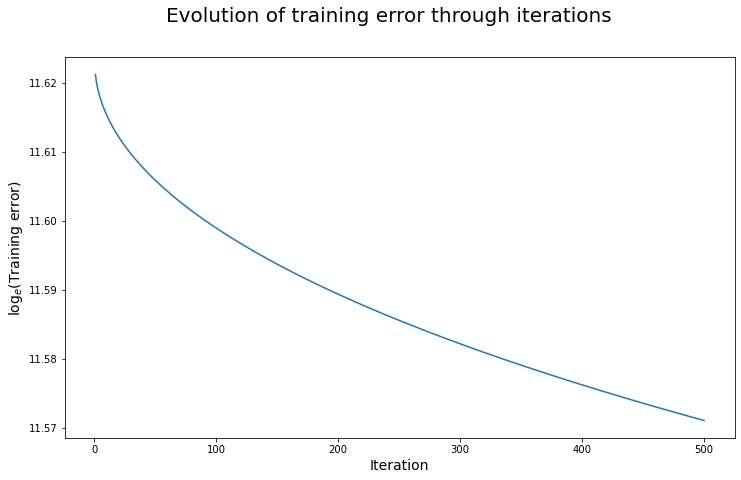

In [129]:
fig = plt.figure(figsize = (12, 7))
plt.plot(np.arange(1, len(errorTrainLR0) + 1), np.log(errorTrainLR0))
fig.suptitle('Evolution of training error through iterations', fontsize=20)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel(r'$\log_e($Training error$)$', fontsize=14)
plt.show()

### Ridge regression via MLlib

To understand the correctness and the performance of our implementation, we can run the same experiment exploiting the implementation of MLib

In [79]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1e-15 #1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 0  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [80]:
firstModel = LinearRegressionWithSGD.train(parsedTrainData,
                                           iterations=numIters,
                                           step=alpha,
                                           miniBatchFraction=miniBatchFrac,
                                           regParam=reg,
                                           regType=regType,
                                           intercept=useIntercept)

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
weightsLR1 = firstModel.weights
interceptLR1 = firstModel.intercept
print(weightsLR1, interceptLR1)

[9.570146438470868e-05,6.571246906741327e-10,6.210217855447338e-07,3.363402040558611e-10,3.530639242232845e-09,0.0001282819640199021,0.00012925036456628842,1.1992563848113321e-08,3.593619993125623e-10,1.2828196401990206e-10,1.5702195861050248e-10,1.6751249000258168e-10,1.2848295513505764e-10,4.142582870512099e-10,3.411976351710257e-10,1.919746252770391e-10,2.5445309849716347e-10,2.483564650147677e-10,2.523961606068469e-10,2.196760391071731e-10,2.031435280753193e-08,2.393479624646188e-10,2.502170929934696e-10,1.973374525884046e-08,7.3141787644253475e-09,1.5768550968444896e-10,2.7169458647953694e-10,1.4769458609318695e-07,1.405491187357085e-10,1.833380191997156e-10,2.1123141129248832e-10,2.5464294850065653e-10,1.285162350495366e-10,9.032742947102422e-10,1.2850901054126583e-10,1.1545376761791194e-09,2.483168471381023e-10,1.284697104635063e-10,1.2869459658492832e-10,1.3016445876485942e-10,2.0856084839529392e-10,1.2848586907276028e-10,4.736360983379025e-05,2.8029977036219345e-10,6.304671986

In [81]:
samplePoint = parsedTrainData.take(1)[0]
samplePrediction = firstModel.predict(samplePoint.features)
print(samplePrediction)

271.26736421875574


In [75]:
parsedTrainData.take(1)[0].label

37100.0

In [18]:
numIters = 1000
regFactor = 1e-6
csi = 1e-15

weightsRR1, errorTrainRR1 = ridgeRegression(parsedTrainData, numIters, csi, regFactor)

labelsAndPreds = parsedValData.map(lambda p: getLabeledPrediction(weightsRR1, p))
rmseValRR1 = calcRMSE(labelsAndPreds)

print('Validation RMSE:\n\tRR0 = {}'.format(rmseValRR1))

[========================================================================] 100%


Ridge regression training with parameters:
	number of iterations = 1000,
	learning rate = 1e-15,        
	regularization factor = 1e-06,
done! Time elapsed: 20 hours 52 minutes 25 seconds




Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 2017.0 failed 1 times, most recent failure: Lost task 7.0 in stage 2017.0 (TID 32089, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "/usr/local/spark/python/pyspark/rdd.py", line 1065, in <lambda>
    return self.mapPartitions(lambda i: [StatCounter(i)]).reduce(redFunc)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/statcounter.py", line 42, in __init__
    for v in values:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-18-78f4da90ecfd>", line 7, in <lambda>
NameError: name 'weightsRR0' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor76.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "/usr/local/spark/python/pyspark/rdd.py", line 1065, in <lambda>
    return self.mapPartitions(lambda i: [StatCounter(i)]).reduce(redFunc)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/statcounter.py", line 42, in __init__
    for v in values:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-18-78f4da90ecfd>", line 7, in <lambda>
NameError: name 'weightsRR0' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$15.apply(RDD.scala:990)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [19]:
labelsAndPreds = parsedValData.map(lambda p: getLabeledPrediction(weightsRR1, p))
rmseValRR1 = calcRMSE(labelsAndPreds)

print('Validation RMSE:\n\tRR0 = {}'.format(rmseValRR1))

Validation RMSE:
	RR0 = 103169.77824815271


In [22]:
print(getLabeledPrediction(weightsRR1, parsedTrainData.take(1)[0]))
print(getLabeledPrediction(weightsRR1, parsedTrainData.take(2)[1]))
print(getLabeledPrediction(weightsRR1, parsedTrainData.take(3)[2]))
print(getLabeledPrediction(weightsRR1, parsedTrainData.take(4)[3]))
print(getLabeledPrediction(weightsRR1, parsedTrainData.take(5)[4]))
print(getLabeledPrediction(weightsRR1, parsedTrainData.take(6)[5]))

(151000.0, 8681.364231503832)
(39930.0, 8770.192731462304)
(11400.0, 9041.645999298622)
(3900.0, 9041.876505225711)
(5400.0, 8670.446538994058)
(136000.0, 9271.281788797158)


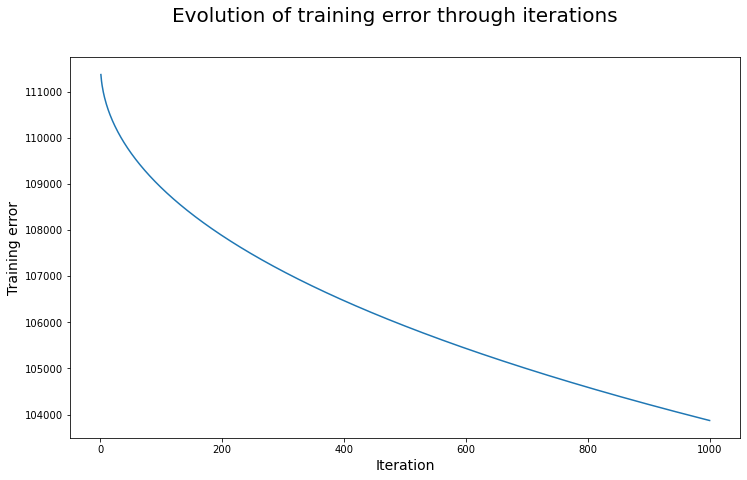

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12, 7))
#plt.plot(np.arange(1, len(errorTrainRR1) + 1), np.log(errorTrainRR1))
plt.plot(np.arange(1, len(errorTrainRR1) + 1), errorTrainRR1)
fig.suptitle('Evolution of training error through iterations', fontsize=20)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Training error', fontsize=14)
plt.show()

In [27]:
print(weightsRR1)

[3.18437453e-03 2.19557823e-08 2.08578594e-05 1.12349232e-08
 1.17915883e-07 4.28773052e-03 4.32009860e-03 3.99894769e-07
 1.21353011e-08 4.28773052e-09 5.16220406e-09 5.59583581e-09
 4.29431228e-09 1.39774175e-08 1.13168340e-08 6.39622766e-09
 8.50461773e-09 8.29669481e-09 8.43858271e-09 7.35002688e-09
 6.86776697e-07 7.99492027e-09 8.39012497e-09 6.62588576e-07
 2.47270170e-07 5.21816786e-09 9.02939864e-09 5.00811018e-06
 4.65840965e-09 6.11693302e-09 7.01302083e-09 8.51172524e-09
 4.29559673e-09 3.05090601e-08 4.29512290e-09 3.85895747e-08
 8.30208633e-09 4.29401955e-09 4.30096639e-09 4.34774247e-09
 6.88092745e-09 4.29442790e-09 1.61489459e-03 9.50090975e-09
 2.13845784e-06 2.31048400e-08 1.07118300e-08 9.60499831e-10
 1.18578964e-09 1.34415596e-08 1.25347763e-09 5.78630029e-09
 8.53567030e-09 1.80322816e-10 1.40808632e-08 1.43786857e-08
 1.41092722e-08 4.30439167e-09 4.36942798e-09 4.47945119e-09
 1.84397511e-08 2.52504879e-09 1.32336568e-08 1.58441867e-11
 4.14403267e-10 2.768027

### Grid search

Now, let us try find a better combination of the hyperparameters running a grid search for different values of the parameters. In this specific case, let us consider the following sets of hyperparameters:

- number of iterations = 10, 50, 100, 250, 500, 1000;
- learning rate =  1e-10, 1e-12, 1e-15;    
- regularization factor = 1e-8, 1e-06, 1e-4, 1e-2, 1e-1, 1.

Running experiment for parameters:
	number of iterations = 5,
	learning rate = 1e-10,             
	regularization parameter = 1e-08
...


[========================================================================] 100%


Ridge regression training with parameters:
	number of iterations = 5,
	learning rate = 1e-10,        
	regularization factor = 1e-08,
done! Time elapsed: 8 minutes


Validation RMSE: = 9195024879868110.0

Predictions on train data:

(151000.0, 6886627164868040.0)
(39930.0, 6934527287068933.0)
(11400.0, 7080900817854221.0)
(3900.0, 7081098467019365.0)
(5400.0, 6880868024538745.0)
(136000.0, 7204872775601875.0)


Weights:
[2.73533444e+09 1.75156537e+04 1.54199949e+07 8.99507011e+03
 9.45208357e+04 3.40638463e+09 3.43209943e+09 3.27001637e+05
 8.40138313e+03 3.40638463e+03 4.96059038e+03 4.45078329e+03
 3.41479156e+03 9.67246097e+03 1.00038630e+04 5.30061603e+03
 6.75974394e+03 6.65188615e+03 6.67557555e+03 5.78581839e+03
 4.59620993e+05 6.43950546e+03 6.39641991e+03 4.39011591e+05
 1.62702962e+05 4.69384982e+03 7.64437701e+03 3.13089392e+06
 4.10758007e+03 4.92015337e+03 6.08628456e+03 6.75525919e+03
 3.41685949e+03 2.08414228e+04 3.41681090e+03 3.06574617e+04
 6.58280345e+03 3.41393832e

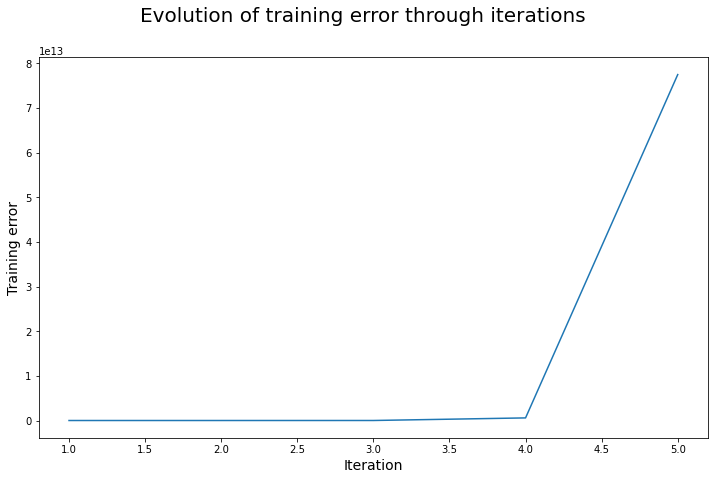


------------------------------------------------------------------------------------------

Running experiment for parameters:
	number of iterations = 10,
	learning rate = 1e-10,             
	regularization parameter = 1e-08
...


[========================================================================] 100%


Ridge regression training with parameters:
	number of iterations = 10,
	learning rate = 1e-10,        
	regularization factor = 1e-08,
done! Time elapsed: 20 minutes 3 seconds


Validation RMSE: = 6.917165981521742e+25

Predictions on train data:

(151000.0, -5.180620909474992e+25)
(39930.0, -5.216654851212431e+25)
(11400.0, -5.326767624158816e+25)
(3900.0, -5.326916310277598e+25)
(5400.0, -5.176288467115688e+25)
(136000.0, -5.420028311332843e+25)


Weights:
[-2.05771810e+19 -1.31765463e+14 -1.16000394e+17 -6.76674475e+13
 -7.11054353e+14 -2.56252982e+19 -2.58187436e+19 -2.45994371e+15
 -6.32013026e+13 -2.56252982e+13 -3.73171626e+13 -3.34820231e+13
 -2.56885412e+13 -7.27632723e+13 -7.52563199e+13 -3.98750821e+13
 -5.08517014e+13 -5.00403168e+13 -5.02185257e+13 -4.35251263e+13
 -3.45760271e+15 -4.84426352e+13 -4.81185142e+13 -3.30256376e+15
 -1.22396977e+15 -3.53105464e+13 -5.75065538e+13 -2.35528554e+16
 -3.09001996e+13 -3.70129657e+13 -4.57854514e+13 -5.08179638e+13
 -2.57040976e+13 

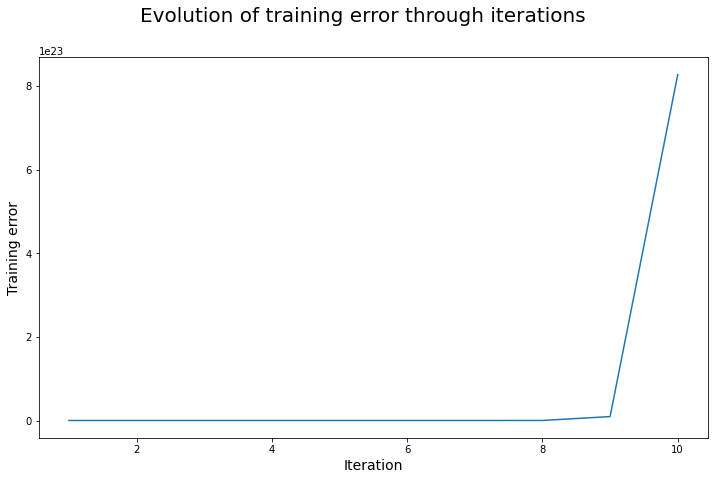


------------------------------------------------------------------------------------------



In [17]:
import matplotlib.pyplot as plt

#numItersParams = [1000]
#csiParams = [1e-10, 1e-15, 1e-20]
#regParams = [1e-8, 1e-6]

numItersParams = [5, 10]
csiParams = [1e-10]
regParams = [1e-8]

for numIters in numItersParams:
    for csi in csiParams:
        for regFactor in regParams:
            print('Running experiment for parameters:\n\tnumber of iterations = {},\n\tlearning rate = {}, \
            \n\tregularization parameter = {}\n...'.format(numIters, csi, regFactor))
            
            weights, errorTrain = ridgeRegression(parsedTrainData, numIters, csi, regFactor)
            labelsAndPreds = parsedValData.map(lambda p: getLabeledPrediction(weights, p))
            rmseValRR = calcRMSE(labelsAndPreds)

            print('Validation RMSE: = {}\n'.format(rmseValRR))
            
            print('Predictions on train data:\n')            
            print(getLabeledPrediction(weights, parsedTrainData.take(1)[0]))
            print(getLabeledPrediction(weights, parsedTrainData.take(2)[1]))
            print(getLabeledPrediction(weights, parsedTrainData.take(3)[2]))
            print(getLabeledPrediction(weights, parsedTrainData.take(4)[3]))
            print(getLabeledPrediction(weights, parsedTrainData.take(5)[4]))
            print(getLabeledPrediction(weights, parsedTrainData.take(6)[5]))
            print('\n')
            
            print('Weights:\n{}\n'.format(weights))
            
            fig = plt.figure(figsize = (12, 7))
            #plt.plot(np.arange(1, len(errorTrain) + 1), np.log(errorTrain))
            plt.plot(np.arange(1, len(errorTrain) + 1), errorTrain)
            fig.suptitle('Evolution of training error through iterations', fontsize = 20)
            plt.xlabel('Iteration', fontsize = 14)
            plt.ylabel('Training error', fontsize = 14)
            plt.show()
            
            print('\n------------------------------------------------------------------------------------------\n')

In [ ]:
numIters = 1500
csi = 1e-12
regFactor = 1e-8

print('Running experiment for parameters:\n\tnumber of iterations = {},\n\tlearning rate = {}, \
         \n\tregularization parameter = {}\n...'.format(numIters, csi, regFactor))
            
weights, errorTrain = ridgeRegression(parsedTrainData, numIters, csi, regFactor)
labelsAndPreds = parsedValData.map(lambda p: getLabeledPrediction(weights, p))
rmseValRR = calcRMSE(labelsAndPreds)

print('Validation RMSE: = {}\n'.format(rmseValRR))
            
print('Predictions on train data:\n')            
print(getLabeledPrediction(weights, parsedTrainData.take(1)[0]))
print(getLabeledPrediction(weights, parsedTrainData.take(2)[1]))
print(getLabeledPrediction(weights, parsedTrainData.take(3)[2]))
print(getLabeledPrediction(weights, parsedTrainData.take(4)[3]))
print(getLabeledPrediction(weights, parsedTrainData.take(5)[4]))
print(getLabeledPrediction(weights, parsedTrainData.take(6)[5]))
print('\n')
            
print('Weights:\n{}\n'.format(weights))
            
fig = plt.figure(figsize = (12, 7))
#plt.plot(np.arange(1, len(errorTrain) + 1), np.log(errorTrain))
plt.plot(np.arange(1, len(errorTrain) + 1), errorTrain)
fig.suptitle('Evolution of training error through iterations', fontsize = 20)
plt.xlabel('Iteration', fontsize = 14)
plt.ylabel('Training error', fontsize = 14)
plt.show()

Running experiment for parameters:
	number of iterations = 1500,
	learning rate = 1e-12,          
	regularization parameter = 1e-08
...
